In [7]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

import sys
sys.path.append('..')
import utils.word_transition_network as wtn_module
from utils.rover import RoverVotingScheme
from utils.word_transition_network import *

from collections import Counter
import collections

from irover_application.extract_features import Processor

In [2]:
import utils.metrics as utils_metrics

In [3]:
import hashlib

In [4]:
import yt.wrapper as yt
yt.config.set_proxy("hahn")

In [5]:
AggregationResult = collections.namedtuple('AggregationResult', 'text confidence cost')

In [6]:
def reproducible_hash(s: str):
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def aggregate_prod(raw_data):
    """
       aggregation from prod
    """
    cost = 2
    while cost < 5:
        cost += 1
        answers = [(x["text"], x["speech"]) for x in raw_data[:cost]]
        answers = Counter(answers)
        if answers.most_common(1)[0][1] >= 3:
            break

    texts = Counter()
    speechs = Counter()
    for text, speech in [(x["text"], x["speech"]) for x in raw_data[:cost]]:
        if speech != "BAD" and text:
            text = text.lower().replace('ё', 'е')
        else:
            text = ""
        speechs.update([speech])
        texts.update([text])

    text, text_rate = max(texts.items(),
                          key=lambda x: (
                              x[1],
                              x[0] != "",
                              -x[0].count('?'),
                              reproducible_hash(x[0])  # for reproducible behavior
                          ))
    if text_rate >= 2:  # and text != "":
        conf = text_rate * 1.0 / sum(texts.values())
    else:
        text = None
        conf = 0
    return AggregationResult(text, conf, cost)

In [8]:
evaluate_metrics = utils_metrics.evaluate_metrics_for_algorithm

In [9]:
valid_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/assistant_ideal_annotations_2019-02-16__2019-02-25"
)
valid_table = list(valid_table)

In [10]:
valid_rows = [row for row in valid_table if row["mark"] == "TEST"]

In [11]:
# Prod baseline
prod_agg_metrics = utils_metrics.evaluate_metrics_for_algorithm(valid_rows, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    aggregate_prod)

Recall: 87.6792%
WER: 13.2758%
Mean overlap: 3.833


In [12]:
def aggregate_rover_with_clf_(rows, features, field_name, clf, treshhold=0.51, min_cost=3, max_cost=10, 
                              cluster_references=None, preaggregated=None):
    """
       aggregation from prod
    """
    clf_results = preaggregated
    if not clf_results:
        clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost: 
                continue
            text = " ".join(value for value, score in item1 if value != "")
            score = sum(score for value, score in item1) / len(item1)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
                if score < treshhold:
                    conf = 0
                    text = None
                else:
                    conf = score
                results[task_id] = AggregationResult(text, conf, cost)
                break
    return results

In [13]:
aggregate_rover_with_clf_

<function __main__.aggregate_rover_with_clf_(rows, features, field_name, clf, treshhold=0.51, min_cost=3, max_cost=10, cluster_references=None, preaggregated=None)>

In [63]:
def evaluate_metrics_clf_(data, 
                          features, 
                          field_name, 
                          clf, 
                          treshhold_common=0.51, 
                          treshhold_exchange=0.51, 
                          min_cost=3, 
                          max_cost=10, 
                          cluster_refernces=None, 
                          print_=True,
                          agg_method=aggregate_rover_with_clf_):
    aggregation_results = agg_method(data, 
                                     features, 
                                     field_name, 
                                     clf, 
                                     treshhold=treshhold_exchange, 
                                     min_cost=min_cost, 
                                     max_cost=max_cost, 
                                     cluster_references=cluster_refernces)
    return utils_metrics.evaluate_metrics_from_dict(data, 
                                              aggregation_results, 
                                              treshhold_common,
                                              cluster_refernces, 
                                              print_)

In [15]:
import matplotlib.pyplot as plt

In [16]:
import pickle

In [20]:
with open('../notebooks/pickled/preaggregated_assistant_with_solo_assistant_question.pickle', 'rb') as f:
    preaggregated = pickle.load(f)
len(preaggregated)

3486

In [21]:
import seaborn as sns
sns.set(style="whitegrid")

In [23]:
def aggregate_rover_with_clf_by_word(rows, features, field_name, clf, threshold_by_word=0.9, treshhold=0.94,
                                     min_cost=3, max_cost=10, cluster_references=None, preaggregated=None):
    """
       experiments with question sign exchange
    """
    clf_results = preaggregated
    if not clf_results:
        clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    changed_signs_in_aggregated = 0
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost:
                continue
            score = sum(score for value, score in item1) / len(item1)
            tokens = [value for value, score_ in item1 if value != ""]
            if score < treshhold:
                tokens = []
                prev_question = False
                for value, score_ in item1:
                    if score_ > threshold_by_word and value != "" and value != "?":
                        tokens.append(value)
                        prev_question = False
                    elif not prev_question and value != "":
                        tokens.append("?")
                        changed_signs_in_aggregated += 1
                        prev_question = True
            text = " ".join(tokens)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
                conf = score
                if text == '?' or (text == '' and score < treshhold):
                    text = None
                results[task_id] = AggregationResult(text, conf, cost)
                break
    return results

In [24]:
preaggregated['1014070/1928ae3a-6351-48cf-bed9-dcb5fa12df6e_f78684d2-2275-4e8b-8839-da3590f59cee_1.opus']

{1: [('', 0.6846747656650313)],
 2: [('', 0.8797422806822525)],
 3: [('', 0.935914017338639)],
 4: [('', 0.9476157703498646)],
 5: [('', 0.9642552025849801)],
 6: [('', 0.9860052903329602)],
 7: [('', 0.9829542698996759)],
 8: [('', 0.9819593114274828)],
 9: [('', 0.9882454214427111)],
 10: [('', 0.9902087289873817)]}

In [25]:
res_with_words = aggregate_rover_with_clf_by_word(valid_rows, 
                                 {},
                                 'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                 None, 
                                 threshold_by_word=0.8210526315789474,
                                 treshhold=0.948,
                                 min_cost=3,
                                 max_cost=7,
                                 preaggregated=preaggregated)

In [26]:
pd.DataFrame(list(res_with_words.values())).sample(20)

,text,confidence,cost
1435,алиса сколько стоят вот эти на пульте управлен...,0.982217,3
1592,совсем совсем картинки мне нужны ну только не ...,0.957188,4
3383,может может ли из за предохранителя гореть мас...,0.963017,3
1697,,0.956204,5
974,алиса привет,0.986470,3
808,отлично,0.987928,3
2326,алиса как мне маме стишок то есть не стишок ал...,0.955459,3
616,что такое правила,0.991862,3
2664,ладно пошла я,0.964554,5
1175,,0.953955,4


In [27]:
from functools import partial
from collections import defaultdict

In [30]:
threshhold = 0.948
baseline_loaded_new_metrics = evaluate_metrics_clf_(valid_rows, 
                                                      {}, 
                                                      'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                                      None, 
                                                      threshhold,
                                                      min_cost=3,
                                                      max_cost=7,
                                                      agg_method=partial(aggregate_rover_with_clf_, 
                                                                         treshhold = threshhold,
                                                                         preaggregated=preaggregated))

Recall: 85.6099%
WER: 6.8220%
Mean overlap: 4.001


In [31]:
baseline_loaded_new_metrics

(0.8560986032503954, 0.06822048315753658, 4.0014343086632245)

In [32]:
scores_clf_score_by_word_q_mean_v3 = defaultdict(list)

for threshhold in [0.945, 0.946, 0.947, 0.948, 0.949, 0.950, 0.951]: # np.linspace(0.89, 0.95, 10):
    print('\n' + str(threshhold))
    for th_by_word in np.linspace(0.9, 1, 21):
        print(th_by_word)
        metrics = evaluate_metrics_clf_(valid_rows, 
                                        {}, 
                                        'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                        None, 
                                        treshhold_exchange=threshhold,
                                        min_cost=3,
                                        max_cost=7,
                                        agg_method=partial(aggregate_rover_with_clf_by_word, 
                                                           threshold_by_word=th_by_word,
                                                           treshhold = threshhold,
                                                           preaggregated=preaggregated))
        scores_clf_score_by_word_q_mean_v3[threshhold].append((th_by_word, *metrics))
    scores_clf_score_by_word_q_mean_v3[threshhold] = np.array(scores_clf_score_by_word_q_mean_v3[threshhold])


0.945
0.9
Recall: 88.5589%
WER: 7.5964%
Mean overlap: 3.948
0.905
Recall: 88.5070%
WER: 7.5344%
Mean overlap: 3.948
0.91
Recall: 88.4156%
WER: 7.5111%
Mean overlap: 3.948
0.915
Recall: 88.3318%
WER: 7.4717%
Mean overlap: 3.948
0.92
Recall: 88.3023%
WER: 7.4714%
Mean overlap: 3.948
0.925
Recall: 88.2613%
WER: 7.4321%
Mean overlap: 3.948
0.93
Recall: 88.2105%
WER: 7.3968%
Mean overlap: 3.948
0.935
Recall: 88.1627%
WER: 7.3891%
Mean overlap: 3.948
0.9400000000000001
Recall: 88.1177%
WER: 7.3439%
Mean overlap: 3.948
0.9450000000000001
Recall: 88.0082%
WER: 7.3295%
Mean overlap: 3.948
0.95
Recall: 87.9128%
WER: 7.3110%
Mean overlap: 3.948
0.9550000000000001
Recall: 87.8174%
WER: 7.2685%
Mean overlap: 3.948
0.96
Recall: 87.7058%
WER: 7.2119%
Mean overlap: 3.948
0.965
Recall: 87.5579%
WER: 7.1440%
Mean overlap: 3.948
0.97
Recall: 87.4629%
WER: 7.1324%
Mean overlap: 3.948
0.975
Recall: 87.3194%
WER: 7.1051%
Mean overlap: 3.948
0.98
Recall: 87.1928%
WER: 7.1067%
Mean overlap: 3.948
0.985
Recal

Recall: 85.5851%
WER: 6.4392%
Mean overlap: 4.077
0.985
Recall: 85.2542%
WER: 6.4604%
Mean overlap: 4.077
0.99
Recall: 84.8707%
WER: 6.4574%
Mean overlap: 4.077
0.995
Recall: 84.6980%
WER: 6.4756%
Mean overlap: 4.077
1.0
Recall: 84.6753%
WER: 6.4806%
Mean overlap: 4.077


In [33]:
with open('../notebooks/pickled/base_line_new_metrics_solo_assistant.pickle', 'rb') as f:
    baseline_loaded_new_metrics = pickle.load(f)
baseline_loaded_new_metrics

array([0.948     , 0.8560986 , 0.06822048, 4.00143431])

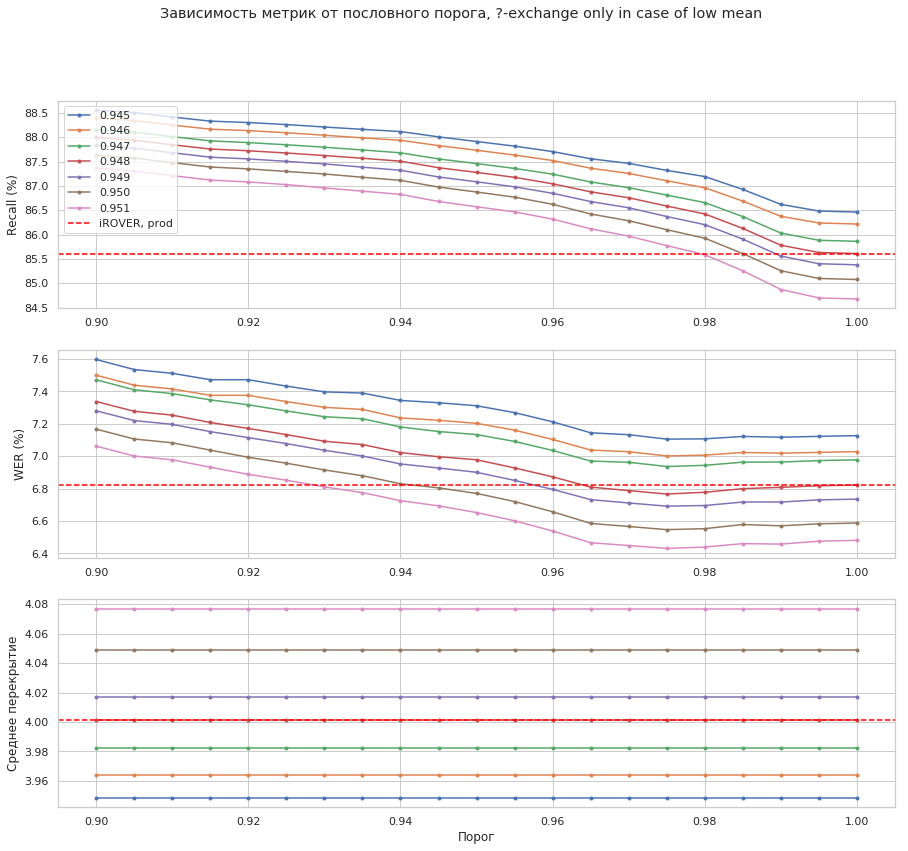

In [61]:
plt.figure(figsize=(15,13))
plt.suptitle('Зависимость метрик от пословного порога, ?-exchange only in case of low mean ')
plt.subplot(311)
for key, value in scores_clf_score_by_word_q_mean_v3.items():
    plt.plot(value[:, 0], 
             value[:, 1] * 100, 
             ".-", 
             label='{:.3f}'.format(key))
#plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, prod")
plt.axhline(y=baseline_loaded_new_metrics[1] * 100, color='red', linestyle='--', label="iROVER, prod")
plt.legend(loc='upper left')
plt.ylabel('Recall (%)')

plt.subplot(312)
for key, value in scores_clf_score_by_word_q_mean_v3.items():
    plt.plot(value[:, 0], 
             value[:, 2] * 100, 
             ".-")
#plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[2] * 100, color='red', linestyle='--')
plt.ylabel('WER (%)')

plt.subplot(313)
for key, value in scores_clf_score_by_word_q_mean_v3.items():
    plt.plot(value[:, 0], 
             value[:, 3], 
             ".-")
#plt.axhline(y=prod_agg_metrics[2], color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[3], color='red', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')
plt.savefig('../notebooks/plots/aggregate_by_word_different_th_by_word.png')
plt.show()

In [199]:
scores_clf_score_by_word_q_mean_v3[0.948][15]

array([0.975     , 0.86586285, 0.06766235, 4.00143431])

In [200]:
baseline_loaded_new_metrics

array([0.948     , 0.8560986 , 0.06822048, 4.00143431])

In [51]:
needed_points = []
default = (None, 0, 1, 10)
for threshold, metrics in scores_clf_score_by_word_q_mean_v3.items():
    prev = default
    for th_by_word, recall, wer, cost in metrics:
        if wer <= prev[2] and wer < baseline_loaded_new_metrics[2] \
            and recall > baseline_loaded_new_metrics[1] and recall > prev[1]:
            prev = ((threshold, round(th_by_word, 3)), recall, wer, cost)
    if prev != default:
        needed_points.append(prev)   
needed_points.append(['baseline'] + list(baseline_loaded_new_metrics[1:]))
needed_points.sort(key=lambda x: x[1], reverse=True)

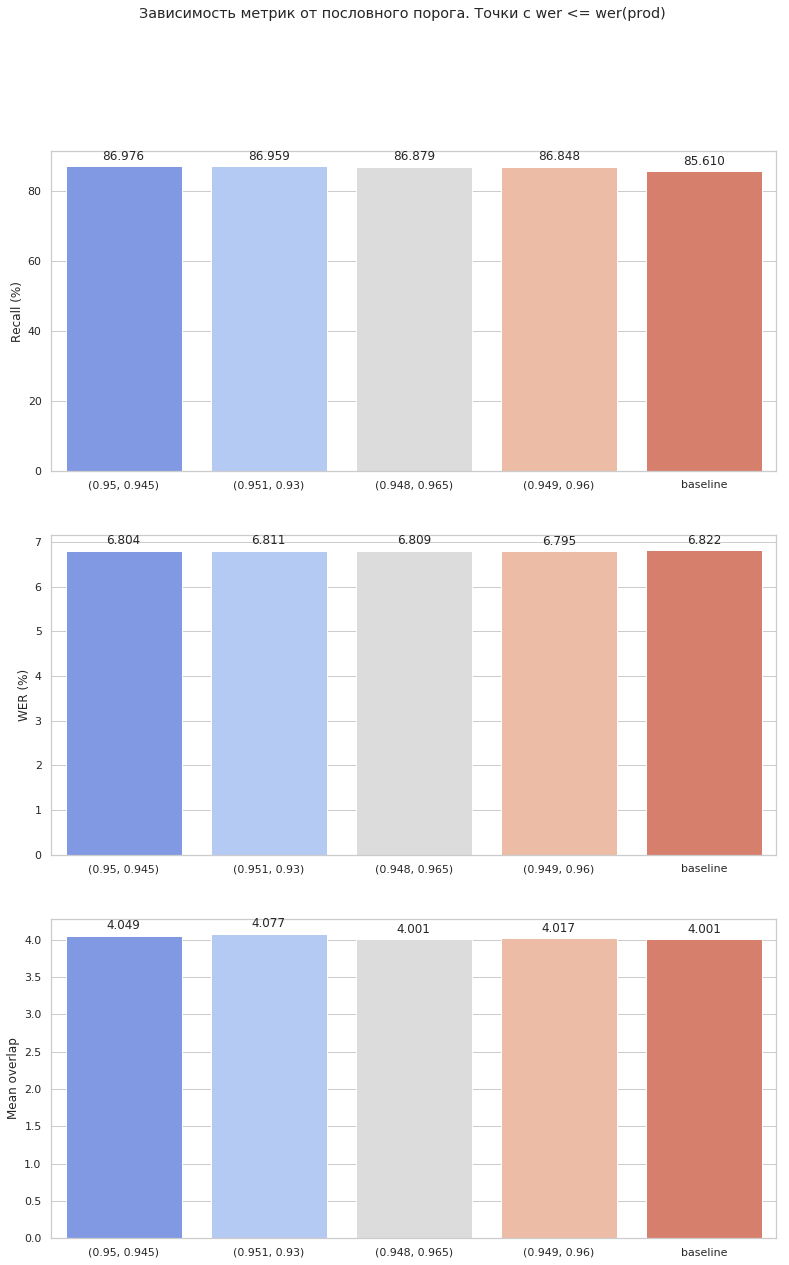

In [60]:
plt.figure(figsize=(13,20))
plt.suptitle('Зависимость метрик от пословного порога. Точки с wer <= wer(prod)')
plt.subplot(311)
plt.ylabel('Recall (%)')
ax = sns.barplot(x=list(map(str, [point[0] for point in needed_points])), 
                 y=[point[1]*100 for point in needed_points],
                 palette="coolwarm")
for item in ax.get_xticklabels():
    item.set_rotation(0)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.3f'), 
                (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), 
                textcoords = 'offset points')

plt.subplot(312)
plt.ylabel('WER (%)')
ax = sns.barplot(x=list(map(str, [point[0] for point in needed_points])), 
                 y=[point[2]*100 for point in needed_points],
                 palette="coolwarm")
for item in ax.get_xticklabels():
    item.set_rotation(0)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.3f'), 
                (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), 
                textcoords = 'offset points')

plt.subplot(313)
plt.ylabel('Mean overlap')
ax = sns.barplot(x=list(map(str, [point[0] for point in needed_points])), 
                 y=[point[3] for point in needed_points],
                 palette="coolwarm")
for item in ax.get_xticklabels():
    item.set_rotation(0)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.3f'), 
                (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig('../notebooks/plots/aggregate_by_word_best_choice.png')
plt.show()

In [65]:
scores_clf_score_by_word_q_mean_v4 = defaultdict(list)

for threshhold_common in np.linspace(0.89, 0.95, 10):
    print('\ncommon: {}'.format(threshhold_common))
    for threshhold_exchange in [threshhold_common + 0.005, threshhold_common + 0.01, threshhold_common + 0.015]:
        print('exchange: {}'.format(threshhold_exchange))
        for th_by_word in np.linspace(0.9, 1, 21):
            print('by word: {}'.format(th_by_word))
            metrics = evaluate_metrics_clf_(valid_rows, 
                                            {}, 
                                            'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                            None, 
                                            threshhold_common,
                                            threshhold_exchange,
                                            min_cost=3,
                                            max_cost=7,
                                            agg_method=partial(aggregate_rover_with_clf_by_word, 
                                                               threshold_by_word=th_by_word,
                                                               treshhold = threshhold,
                                                               preaggregated=preaggregated))
            scores_clf_score_by_word_q_mean_v4[(threshhold_common, threshhold_exchange)].append((th_by_word, *metrics))
    scores_clf_score_by_word_q_mean_v4[(threshhold_common, threshhold_exchange)] = np.array(scores_clf_score_by_word_q_mean_v4[(threshhold_common, threshhold_exchange)])



common: 0.89
exchange: 0.895
by word: 0.9
Recall: 93.4997%
WER: 11.2426%
Mean overlap: 3.352
by word: 0.905
Recall: 93.4984%
WER: 11.2351%
Mean overlap: 3.352
by word: 0.91
Recall: 93.4963%
WER: 11.2360%
Mean overlap: 3.352
by word: 0.915
Recall: 93.4933%
WER: 11.2376%
Mean overlap: 3.352
by word: 0.92
Recall: 93.4918%
WER: 11.2385%
Mean overlap: 3.352
by word: 0.925
Recall: 93.4875%
WER: 11.2335%
Mean overlap: 3.352
by word: 0.93
Recall: 93.4875%
WER: 11.2335%
Mean overlap: 3.352
by word: 0.935
Recall: 93.4831%
WER: 11.2352%
Mean overlap: 3.352
by word: 0.9400000000000001
Recall: 93.4831%
WER: 11.2352%
Mean overlap: 3.352
by word: 0.9450000000000001
Recall: 93.4831%
WER: 11.2352%
Mean overlap: 3.352
by word: 0.95
Recall: 93.4816%
WER: 11.2360%
Mean overlap: 3.352
by word: 0.9550000000000001
Recall: 93.4802%
WER: 11.2369%
Mean overlap: 3.352
by word: 0.96
Recall: 93.4802%
WER: 11.2369%
Mean overlap: 3.352
by word: 0.965
Recall: 93.4802%
WER: 11.2369%
Mean overlap: 3.352
by word: 0.97


Recall: 92.3026%
WER: 10.2369%
Mean overlap: 3.474
by word: 0.975
Recall: 92.2947%
WER: 10.2309%
Mean overlap: 3.474
by word: 0.98
Recall: 92.2788%
WER: 10.2340%
Mean overlap: 3.474
by word: 0.985
Recall: 92.2606%
WER: 10.2311%
Mean overlap: 3.474
by word: 0.99
Recall: 92.2448%
WER: 10.2350%
Mean overlap: 3.474
by word: 0.995
Recall: 92.2419%
WER: 10.2357%
Mean overlap: 3.474
by word: 1.0
Recall: 92.2419%
WER: 10.2357%
Mean overlap: 3.474

common: 0.9033333333333333
exchange: 0.9083333333333333
by word: 0.9
Recall: 92.6205%
WER: 10.4528%
Mean overlap: 3.446
by word: 0.905
Recall: 92.6205%
WER: 10.4528%
Mean overlap: 3.446
by word: 0.91
Recall: 92.6205%
WER: 10.4528%
Mean overlap: 3.446
by word: 0.915
Recall: 92.6205%
WER: 10.4528%
Mean overlap: 3.446
by word: 0.92
Recall: 92.6164%
WER: 10.4544%
Mean overlap: 3.446
by word: 0.925
Recall: 92.6164%
WER: 10.4544%
Mean overlap: 3.446
by word: 0.93
Recall: 92.6143%
WER: 10.4552%
Mean overlap: 3.446
by word: 0.935
Recall: 92.6123%
WER: 10.456

Recall: 91.1744%
WER: 9.4925%
Mean overlap: 3.568
by word: 0.9550000000000001
Recall: 91.1540%
WER: 9.4808%
Mean overlap: 3.568
by word: 0.96
Recall: 91.1520%
WER: 9.4815%
Mean overlap: 3.568
by word: 0.965
Recall: 91.1452%
WER: 9.4844%
Mean overlap: 3.568
by word: 0.97
Recall: 91.1414%
WER: 9.4859%
Mean overlap: 3.568
by word: 0.975
Recall: 91.1378%
WER: 9.4874%
Mean overlap: 3.568
by word: 0.98
Recall: 91.1336%
WER: 9.4888%
Mean overlap: 3.568
by word: 0.985
Recall: 91.1292%
WER: 9.4903%
Mean overlap: 3.568
by word: 0.99
Recall: 91.1268%
WER: 9.4910%
Mean overlap: 3.568
by word: 0.995
Recall: 91.1172%
WER: 9.4925%
Mean overlap: 3.568
by word: 1.0
Recall: 91.1172%
WER: 9.4925%
Mean overlap: 3.568
exchange: 0.9266666666666666
by word: 0.9
Recall: 90.4745%
WER: 9.0012%
Mean overlap: 3.629
by word: 0.905
Recall: 90.4699%
WER: 8.9949%
Mean overlap: 3.629
by word: 0.91
Recall: 90.4312%
WER: 8.9899%
Mean overlap: 3.629
by word: 0.915
Recall: 90.4231%
WER: 8.9920%
Mean overlap: 3.629
by word

Recall: 88.8965%
WER: 8.1336%
Mean overlap: 3.743
by word: 0.93
Recall: 88.8941%
WER: 8.1342%
Mean overlap: 3.743
by word: 0.935
Recall: 88.8941%
WER: 8.1342%
Mean overlap: 3.743
by word: 0.9400000000000001
Recall: 88.8941%
WER: 8.1342%
Mean overlap: 3.743
by word: 0.9450000000000001
Recall: 88.8858%
WER: 8.1362%
Mean overlap: 3.743
by word: 0.95
Recall: 88.8769%
WER: 8.1308%
Mean overlap: 3.743
by word: 0.9550000000000001
Recall: 88.8733%
WER: 8.1228%
Mean overlap: 3.743
by word: 0.96
Recall: 88.8710%
WER: 8.1235%
Mean overlap: 3.743
by word: 0.965
Recall: 88.8650%
WER: 8.1254%
Mean overlap: 3.743
by word: 0.97
Recall: 88.8597%
WER: 8.1267%
Mean overlap: 3.743
by word: 0.975
Recall: 88.8472%
WER: 8.1306%
Mean overlap: 3.743
by word: 0.98
Recall: 88.8365%
WER: 8.1252%
Mean overlap: 3.743
by word: 0.985
Recall: 88.8141%
WER: 8.1304%
Mean overlap: 3.743
by word: 0.99
Recall: 88.7930%
WER: 8.1369%
Mean overlap: 3.743
by word: 0.995
Recall: 88.7810%
WER: 8.1408%
Mean overlap: 3.743
by word

Recall: 85.7211%
WER: 6.8632%
Mean overlap: 4.005
by word: 0.905
Recall: 85.7130%
WER: 6.8649%
Mean overlap: 4.005
by word: 0.91
Recall: 85.7130%
WER: 6.8649%
Mean overlap: 4.005
by word: 0.915
Recall: 85.7121%
WER: 6.8582%
Mean overlap: 4.005
by word: 0.92
Recall: 85.7058%
WER: 6.8195%
Mean overlap: 4.005
by word: 0.925
Recall: 85.7051%
WER: 6.8201%
Mean overlap: 4.005
by word: 0.93
Recall: 85.7035%
WER: 6.8145%
Mean overlap: 4.005
by word: 0.935
Recall: 85.6880%
WER: 6.7921%
Mean overlap: 4.005
by word: 0.9400000000000001
Recall: 85.6868%
WER: 6.7938%
Mean overlap: 4.005
by word: 0.9450000000000001
Recall: 85.6762%
WER: 6.7973%
Mean overlap: 4.005
by word: 0.95
Recall: 85.6731%
WER: 6.7900%
Mean overlap: 4.005
by word: 0.9550000000000001
Recall: 85.6652%
WER: 6.7675%
Mean overlap: 4.005
by word: 0.96
Recall: 85.6286%
WER: 6.7642%
Mean overlap: 4.005
by word: 0.965
Recall: 85.6270%
WER: 6.7659%
Mean overlap: 4.005
by word: 0.97
Recall: 85.6130%
WER: 6.7547%
Mean overlap: 4.005
by word

Recall: 78.5675%
WER: 4.9740%
Mean overlap: 4.522
by word: 0.99
Recall: 78.2724%
WER: 4.9756%
Mean overlap: 4.522
by word: 0.995
Recall: 78.0224%
WER: 5.0164%
Mean overlap: 4.522
by word: 1.0
Recall: 78.0151%
WER: 5.0208%
Mean overlap: 4.522


In [70]:
scores_clf_score_by_word_q_mean_v5 = {}
for key, value in scores_clf_score_by_word_q_mean_v4.items():
    scores_clf_score_by_word_q_mean_v5[key] = np.array(value)

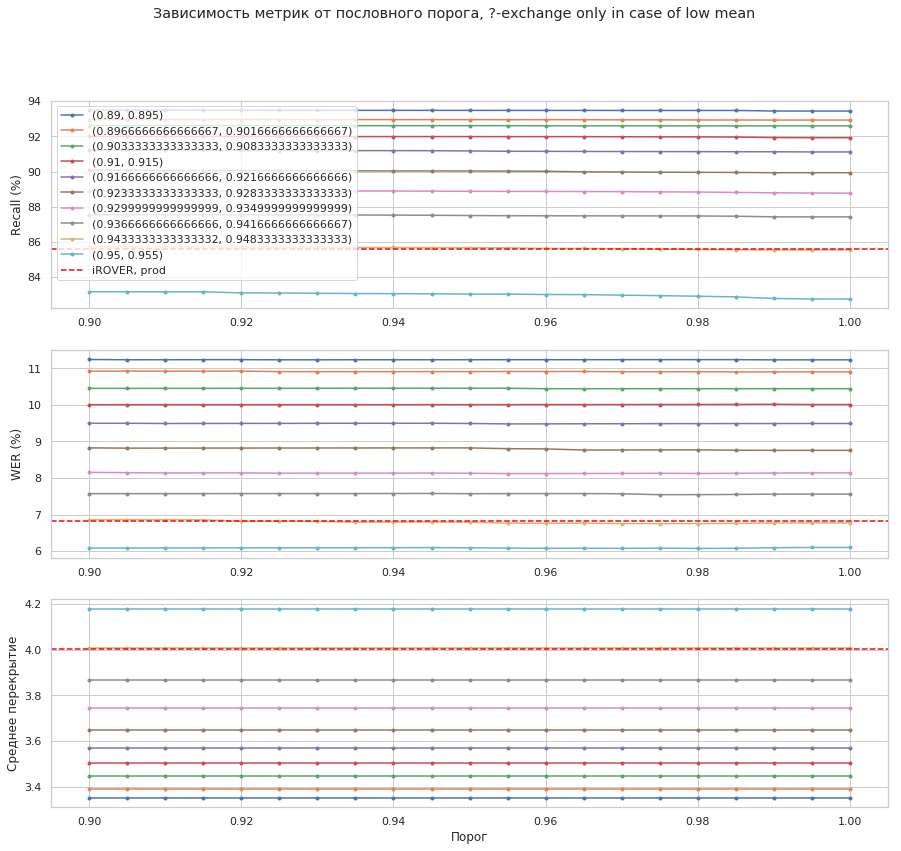

In [82]:
plt.figure(figsize=(15,13))
plt.suptitle('Зависимость метрик от пословного порога, ?-exchange only in case of low mean ')
plt.subplot(311)
dif = 0.005
for key, value in scores_clf_score_by_word_q_mean_v5.items():
    if round(key[1] - key[0], 3) == 0.005:
        plt.plot(value[:, 0], 
                 value[:, 1] * 100, 
                 ".-", 
                 label=str(key))
#plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, prod")
plt.axhline(y=baseline_loaded_new_metrics[1] * 100, color='red', linestyle='--', label="iROVER, prod")
plt.legend(loc='upper left')
plt.ylabel('Recall (%)')

plt.subplot(312)
for key, value in scores_clf_score_by_word_q_mean_v5.items():
    if round(key[1] - key[0], 3) == 0.005:
        plt.plot(value[:, 0], 
                 value[:, 2] * 100, 
                 ".-")
#plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[2] * 100, color='red', linestyle='--')
plt.ylabel('WER (%)')

plt.subplot(313)
for key, value in scores_clf_score_by_word_q_mean_v5.items():
    if round(key[1] - key[0], 3) == 0.005:
        plt.plot(value[:, 0], 
                 value[:, 3], 
                 ".-")
#plt.axhline(y=prod_agg_metrics[2], color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[3], color='red', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')
plt.savefig('../notebooks/plots/aggregate_by_word_3_thresholds_0_005.png')
plt.show()

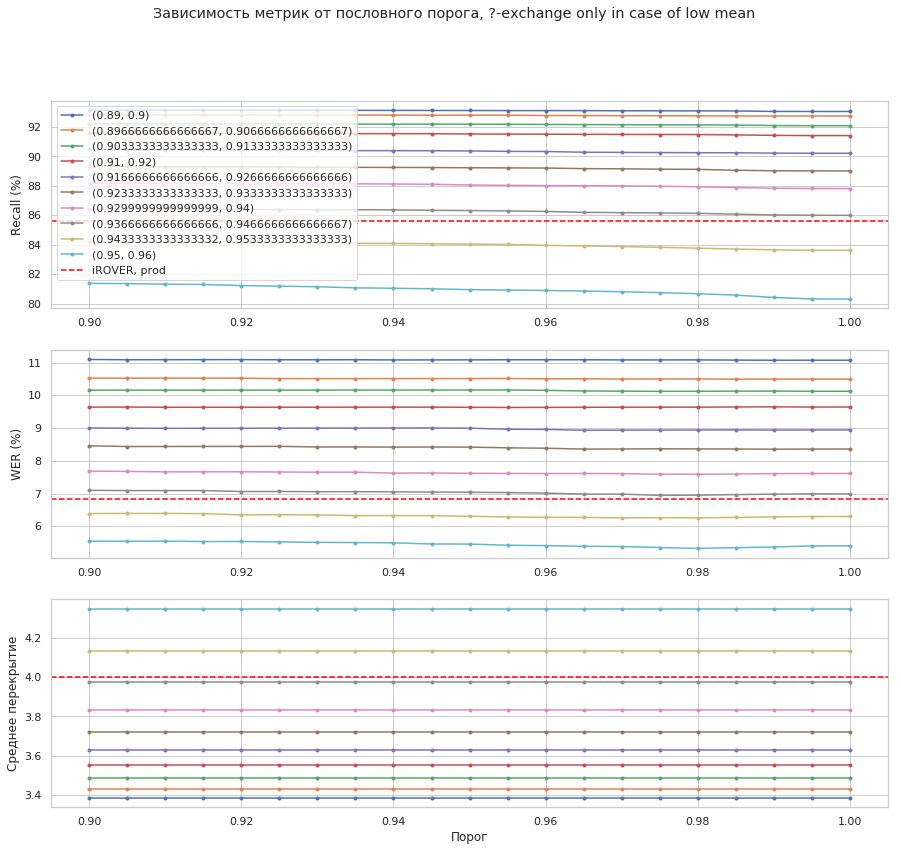

In [83]:
plt.figure(figsize=(15,13))
plt.suptitle('Зависимость метрик от пословного порога, ?-exchange only in case of low mean ')
plt.subplot(311)
dif = 0.01
for key, value in scores_clf_score_by_word_q_mean_v5.items():
    if round(key[1] - key[0], 3) == dif:
        plt.plot(value[:, 0], 
                 value[:, 1] * 100, 
                 ".-", 
                 label=str(key))
#plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, prod")
plt.axhline(y=baseline_loaded_new_metrics[1] * 100, color='red', linestyle='--', label="iROVER, prod")
plt.legend(loc='upper left')
plt.ylabel('Recall (%)')

plt.subplot(312)
for key, value in scores_clf_score_by_word_q_mean_v5.items():
    if round(key[1] - key[0], 3) == dif:
        plt.plot(value[:, 0], 
                 value[:, 2] * 100, 
                 ".-")
#plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[2] * 100, color='red', linestyle='--')
plt.ylabel('WER (%)')

plt.subplot(313)
for key, value in scores_clf_score_by_word_q_mean_v5.items():
    if round(key[1] - key[0], 3) == dif:
        plt.plot(value[:, 0], 
                 value[:, 3], 
                 ".-")
#plt.axhline(y=prod_agg_metrics[2], color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[3], color='red', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')
plt.savefig('../notebooks/plots/aggregate_by_word_3_thresholds_0_01.png')
plt.show()

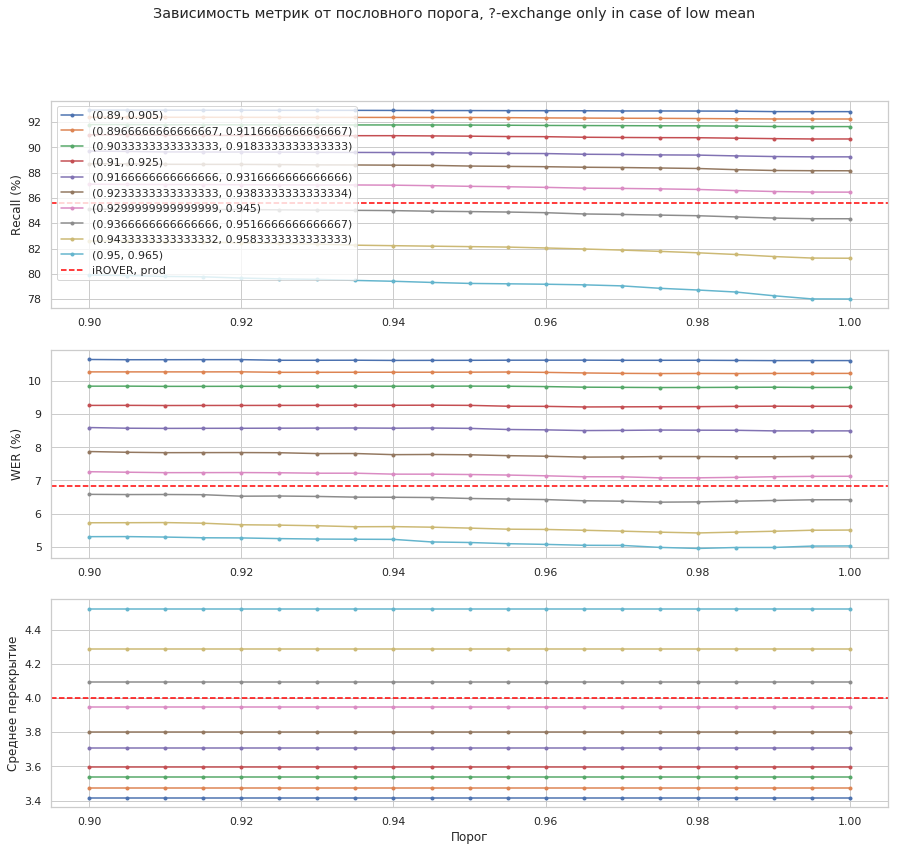

In [89]:
plt.figure(figsize=(15,13))
plt.suptitle('Зависимость метрик от пословного порога, ?-exchange only in case of low mean ')
plt.subplot(311)
dif = 0.015
for key, value in scores_clf_score_by_word_q_mean_v5.items():
    if round(key[1] - key[0], 3) == dif:
        plt.plot(value[:, 0], 
                 value[:, 1] * 100, 
                 ".-", 
                 label=str(key))
#plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, prod")
plt.axhline(y=baseline_loaded_new_metrics[1] * 100, color='red', linestyle='--', label="iROVER, prod")
plt.legend(loc='upper left')
plt.ylabel('Recall (%)')

plt.subplot(312)
for key, value in scores_clf_score_by_word_q_mean_v5.items():
    if round(key[1] - key[0], 3) == dif:
        plt.plot(value[:, 0], 
                 value[:, 2] * 100, 
                 ".-")
#plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[2] * 100, color='red', linestyle='--')
plt.ylabel('WER (%)')

plt.subplot(313)
for key, value in scores_clf_score_by_word_q_mean_v5.items():
    if round(key[1] - key[0], 3) == dif:
        plt.plot(value[:, 0], 
                 value[:, 3], 
                 ".-")
#plt.axhline(y=prod_agg_metrics[2], color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[3], color='red', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')
plt.savefig('../notebooks/plots/aggregate_by_word_3_thresholds_0_015.png')
plt.show()

In [85]:
scores_clf_score_by_word_q_mean_v6 = defaultdict(list)

for threshhold_common in np.linspace(0.89, 0.95, 10):
    print('\ncommon: {}'.format(threshhold_common))
    for threshhold_exchange in [threshhold_common + 0.02, threshhold_common + 0.025, threshhold_common + 0.03]:
        print('exchange: {}'.format(threshhold_exchange))
        for th_by_word in np.linspace(0.9, 1, 21):
            print('by word: {}'.format(th_by_word))
            metrics = evaluate_metrics_clf_(valid_rows, 
                                            {}, 
                                            'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                            None, 
                                            threshhold_common,
                                            threshhold_exchange,
                                            min_cost=3,
                                            max_cost=7,
                                            agg_method=partial(aggregate_rover_with_clf_by_word, 
                                                               threshold_by_word=th_by_word,
                                                               treshhold = threshhold,
                                                               preaggregated=preaggregated))
            scores_clf_score_by_word_q_mean_v6[(threshhold_common, threshhold_exchange)].append((th_by_word, *metrics))
    scores_clf_score_by_word_q_mean_v6[(threshhold_common, threshhold_exchange)] = np.array(scores_clf_score_by_word_q_mean_v6[(threshhold_common, threshhold_exchange)])



common: 0.89
exchange: 0.91
by word: 0.9
Recall: 92.6389%
WER: 10.4632%
Mean overlap: 3.459
by word: 0.905
Recall: 92.6376%
WER: 10.4556%
Mean overlap: 3.459
by word: 0.91
Recall: 92.6320%
WER: 10.4564%
Mean overlap: 3.459
by word: 0.915
Recall: 92.6218%
WER: 10.4588%
Mean overlap: 3.459
by word: 0.92
Recall: 92.6163%
WER: 10.4612%
Mean overlap: 3.459
by word: 0.925
Recall: 92.1676%
WER: 10.0517%
Mean overlap: 3.506
by word: 0.9400000000000001
Recall: 92.1612%
WER: 10.0456%
Mean overlap: 3.506
by word: 0.9450000000000001
Recall: 92.1515%
WER: 10.0479%
Mean overlap: 3.506
by word: 0.95
Recall: 92.1461%
WER: 10.0509%
Mean overlap: 3.506
by word: 0.9550000000000001
Recall: 92.1272%
WER: 10.0571%
Mean overlap: 3.506
by word: 0.96
Recall: 92.1040%
WER: 10.0480%
Mean overlap: 3.506
by word: 0.965
Recall: 92.0899%
WER: 10.0312%
Mean overlap: 3.506
by word: 0.97
Recall: 92.0663%
WER: 10.0213%
Mean overlap: 3.506
by word: 0.975
Recall: 92.0476%
WER: 10.0168%
Mean overlap: 3.506
by word: 0.98
R

Recall: 91.0262%
WER: 9.4560%
Mean overlap: 3.584
by word: 0.99
Recall: 90.9827%
WER: 9.4626%
Mean overlap: 3.584
by word: 0.995
Recall: 90.9595%
WER: 9.4585%
Mean overlap: 3.584
by word: 1.0
Recall: 90.9595%
WER: 9.4585%
Mean overlap: 3.584
exchange: 0.9283333333333333
by word: 0.9
Recall: 90.4541%
WER: 8.8767%
Mean overlap: 3.649
by word: 0.905
Recall: 90.4447%
WER: 8.8710%
Mean overlap: 3.649
by word: 0.91
Recall: 90.4060%
WER: 8.8660%
Mean overlap: 3.649
by word: 0.915
Recall: 90.3966%
WER: 8.8694%
Mean overlap: 3.649
by word: 0.92
Recall: 90.3907%
WER: 8.8715%
Mean overlap: 3.649
by word: 0.925
Recall: 90.3816%
WER: 8.8658%
Mean overlap: 3.649
by word: 0.93
Recall: 90.3718%
WER: 8.8685%
Mean overlap: 3.649
by word: 0.935
Recall: 90.3489%
WER: 8.8727%
Mean overlap: 3.649
by word: 0.9400000000000001
Recall: 90.3428%
WER: 8.8663%
Mean overlap: 3.649
by word: 0.9450000000000001
Recall: 90.3251%
WER: 8.8683%
Mean overlap: 3.649
by word: 0.95
Recall: 90.2949%
WER: 8.8654%
Mean overlap: 

Recall: 88.9405%
WER: 7.9936%
Mean overlap: 3.773
by word: 0.965
Recall: 88.8812%
WER: 7.9726%
Mean overlap: 3.773
by word: 0.97
Recall: 88.8521%
WER: 7.9802%
Mean overlap: 3.773
by word: 0.975
Recall: 88.8114%
WER: 7.9923%
Mean overlap: 3.773
by word: 0.98
Recall: 88.7708%
WER: 7.9926%
Mean overlap: 3.773
by word: 0.985
Recall: 88.6759%
WER: 7.9891%
Mean overlap: 3.773
by word: 0.99
Recall: 88.6041%
WER: 7.9688%
Mean overlap: 3.773
by word: 0.995
Recall: 88.5684%
WER: 7.9717%
Mean overlap: 3.773
by word: 1.0
Recall: 88.5630%
WER: 7.9736%
Mean overlap: 3.773
exchange: 0.9416666666666667
by word: 0.9
Recall: 88.3224%
WER: 7.7507%
Mean overlap: 3.867
by word: 0.905
Recall: 88.2995%
WER: 7.7298%
Mean overlap: 3.867
by word: 0.91
Recall: 88.2543%
WER: 7.7114%
Mean overlap: 3.867
by word: 0.915
Recall: 88.2423%
WER: 7.7145%
Mean overlap: 3.867
by word: 0.92
Recall: 88.2321%
WER: 7.7176%
Mean overlap: 3.867
by word: 0.925
Recall: 88.2141%
WER: 7.7133%
Mean overlap: 3.867
by word: 0.93
Recall

Recall: 85.9161%
WER: 6.6439%
Mean overlap: 4.049
by word: 0.9450000000000001
Recall: 85.8598%
WER: 6.6467%
Mean overlap: 4.049
by word: 0.95
Recall: 85.8038%
WER: 6.6205%
Mean overlap: 4.049
by word: 0.9550000000000001
Recall: 85.7585%
WER: 6.5981%
Mean overlap: 4.049
by word: 0.96
Recall: 85.6926%
WER: 6.5767%
Mean overlap: 4.049
by word: 0.965
Recall: 85.5820%
WER: 6.5447%
Mean overlap: 4.049
by word: 0.97
Recall: 85.5379%
WER: 6.5333%
Mean overlap: 4.049
by word: 0.975
Recall: 85.4642%
WER: 6.5104%
Mean overlap: 4.049
by word: 0.98
Recall: 85.3770%
WER: 6.5155%
Mean overlap: 4.049
by word: 0.985
Recall: 85.2485%
WER: 6.5408%
Mean overlap: 4.049
by word: 0.99
Recall: 85.1441%
WER: 6.5652%
Mean overlap: 4.049
by word: 0.995
Recall: 85.0848%
WER: 6.5844%
Mean overlap: 4.049
by word: 1.0
Recall: 85.0765%
WER: 6.5872%
Mean overlap: 4.049
exchange: 0.955
by word: 0.9
Recall: 84.3550%
WER: 6.3234%
Mean overlap: 4.178
by word: 0.905
Recall: 84.3262%
WER: 6.3098%
Mean overlap: 4.178
by word

Recall: 80.8359%
WER: 5.5266%
Mean overlap: 4.454
by word: 0.92
Recall: 80.7229%
WER: 5.4730%
Mean overlap: 4.454
by word: 0.925
Recall: 80.6666%
WER: 5.4631%
Mean overlap: 4.454
by word: 0.93
Recall: 80.6154%
WER: 5.4447%
Mean overlap: 4.454
by word: 0.935
Recall: 80.5161%
WER: 5.4160%
Mean overlap: 4.454
by word: 0.9400000000000001
Recall: 80.4263%
WER: 5.4143%
Mean overlap: 4.454
by word: 0.9450000000000001
Recall: 80.3492%
WER: 5.3321%
Mean overlap: 4.454
by word: 0.95
Recall: 80.2612%
WER: 5.2909%
Mean overlap: 4.454
by word: 0.9550000000000001
Recall: 80.2124%
WER: 5.2349%
Mean overlap: 4.454
by word: 0.96
Recall: 80.1208%
WER: 5.2040%
Mean overlap: 4.454
by word: 0.965
Recall: 80.0034%
WER: 5.1388%
Mean overlap: 4.454
by word: 0.97
Recall: 79.8685%
WER: 5.1178%
Mean overlap: 4.454
by word: 0.975
Recall: 79.6501%
WER: 5.0606%
Mean overlap: 4.454
by word: 0.98
Recall: 79.4582%
WER: 5.0350%
Mean overlap: 4.454
by word: 0.985
Recall: 79.2504%
WER: 5.0675%
Mean overlap: 4.454
by word

Recall: 65.1366%
WER: 2.9031%
Mean overlap: 5.176


In [87]:
for key, value in scores_clf_score_by_word_q_mean_v6.items():
    scores_clf_score_by_word_q_mean_v6[key] = np.array(value)

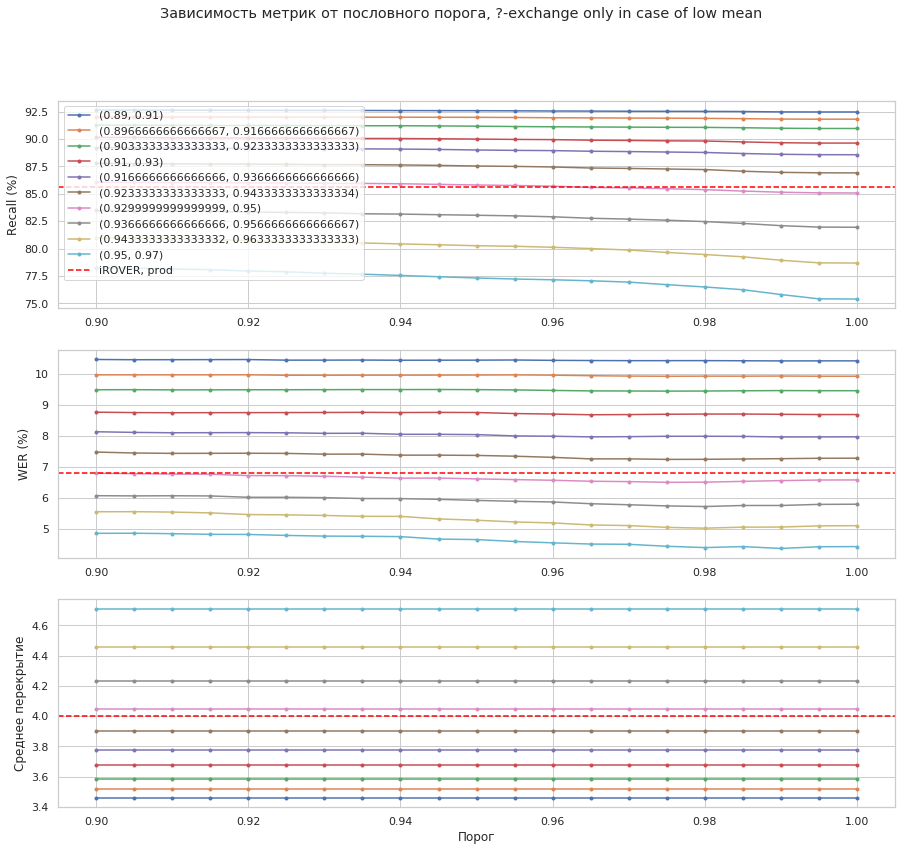

In [90]:
plt.figure(figsize=(15,13))
plt.suptitle('Зависимость метрик от пословного порога, ?-exchange only in case of low mean ')
plt.subplot(311)
dif = 0.02
for key, value in scores_clf_score_by_word_q_mean_v6.items():
    if round(key[1] - key[0], 3) == dif:
        plt.plot(value[:, 0], 
                 value[:, 1] * 100, 
                 ".-", 
                 label=str(key))
#plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, prod")
plt.axhline(y=baseline_loaded_new_metrics[1] * 100, color='red', linestyle='--', label="iROVER, prod")
plt.legend(loc='upper left')
plt.ylabel('Recall (%)')

plt.subplot(312)
for key, value in scores_clf_score_by_word_q_mean_v6.items():
    if round(key[1] - key[0], 3) == dif:
        plt.plot(value[:, 0], 
                 value[:, 2] * 100, 
                 ".-")
#plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[2] * 100, color='red', linestyle='--')
plt.ylabel('WER (%)')

plt.subplot(313)
for key, value in scores_clf_score_by_word_q_mean_v6.items():
    if round(key[1] - key[0], 3) == dif:
        plt.plot(value[:, 0], 
                 value[:, 3], 
                 ".-")
#plt.axhline(y=prod_agg_metrics[2], color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[3], color='red', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')
plt.savefig('../notebooks/plots/aggregate_by_word_3_thresholds_0_02.png')
plt.show()

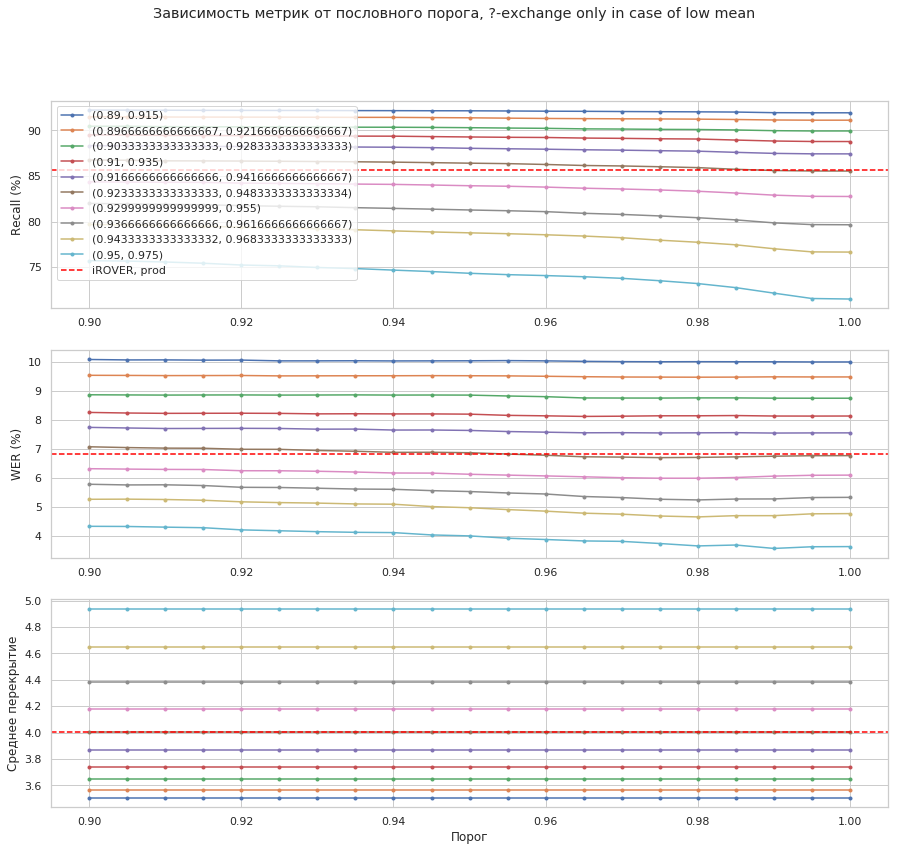

In [91]:
plt.figure(figsize=(15,13))
plt.suptitle('Зависимость метрик от пословного порога, ?-exchange only in case of low mean ')
plt.subplot(311)
dif = 0.025
for key, value in scores_clf_score_by_word_q_mean_v6.items():
    if round(key[1] - key[0], 3) == dif:
        plt.plot(value[:, 0], 
                 value[:, 1] * 100, 
                 ".-", 
                 label=str(key))
#plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, prod")
plt.axhline(y=baseline_loaded_new_metrics[1] * 100, color='red', linestyle='--', label="iROVER, prod")
plt.legend(loc='upper left')
plt.ylabel('Recall (%)')

plt.subplot(312)
for key, value in scores_clf_score_by_word_q_mean_v6.items():
    if round(key[1] - key[0], 3) == dif:
        plt.plot(value[:, 0], 
                 value[:, 2] * 100, 
                 ".-")
#plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[2] * 100, color='red', linestyle='--')
plt.ylabel('WER (%)')

plt.subplot(313)
for key, value in scores_clf_score_by_word_q_mean_v6.items():
    if round(key[1] - key[0], 3) == dif:
        plt.plot(value[:, 0], 
                 value[:, 3], 
                 ".-")
#plt.axhline(y=prod_agg_metrics[2], color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[3], color='red', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')
plt.savefig('../notebooks/plots/aggregate_by_word_3_thresholds_0_025.png')
plt.show()

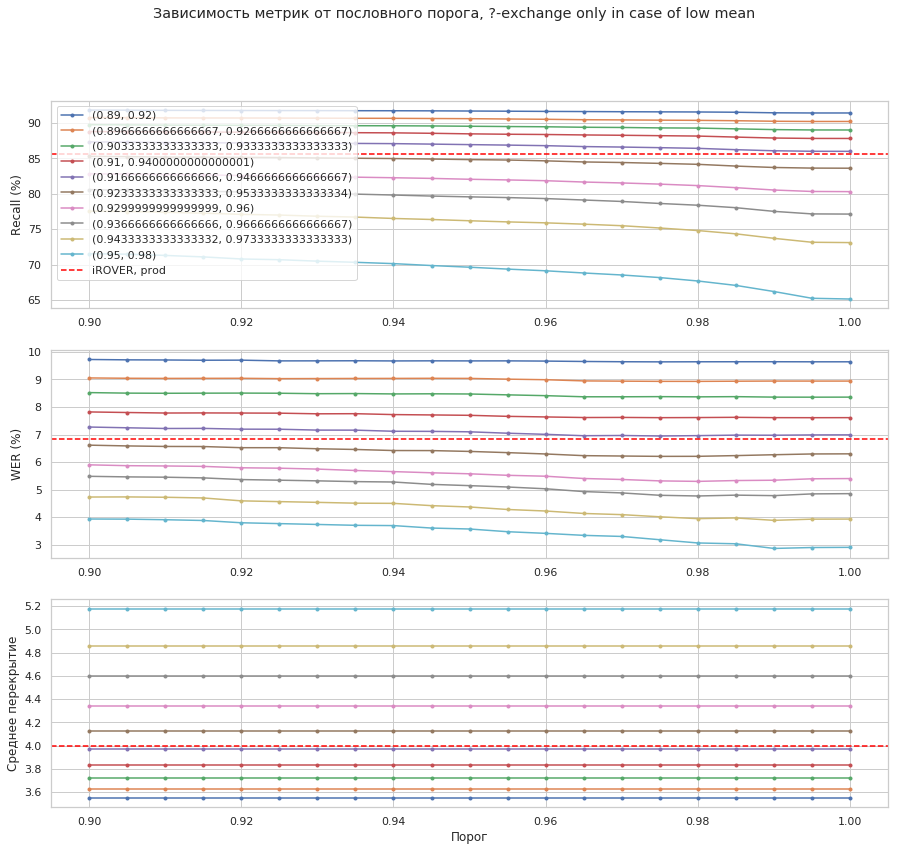

In [92]:
plt.figure(figsize=(15,13))
plt.suptitle('Зависимость метрик от пословного порога, ?-exchange only in case of low mean ')
plt.subplot(311)
dif = 0.03
for key, value in scores_clf_score_by_word_q_mean_v6.items():
    if round(key[1] - key[0], 3) == dif:
        plt.plot(value[:, 0], 
                 value[:, 1] * 100, 
                 ".-", 
                 label=str(key))
#plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, prod")
plt.axhline(y=baseline_loaded_new_metrics[1] * 100, color='red', linestyle='--', label="iROVER, prod")
plt.legend(loc='upper left')
plt.ylabel('Recall (%)')

plt.subplot(312)
for key, value in scores_clf_score_by_word_q_mean_v6.items():
    if round(key[1] - key[0], 3) == dif:
        plt.plot(value[:, 0], 
                 value[:, 2] * 100, 
                 ".-")
#plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[2] * 100, color='red', linestyle='--')
plt.ylabel('WER (%)')

plt.subplot(313)
for key, value in scores_clf_score_by_word_q_mean_v6.items():
    if round(key[1] - key[0], 3) == dif:
        plt.plot(value[:, 0], 
                 value[:, 3], 
                 ".-")
#plt.axhline(y=prod_agg_metrics[2], color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[3], color='red', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')
plt.savefig('../notebooks/plots/aggregate_by_word_3_thresholds_0_03.png')
plt.show()

In [121]:
scores_clf_score_by_word_q_mean_v6.keys()

dict_keys([(0.89, 0.91), (0.89, 0.915), (0.89, 0.92), (0.8966666666666667, 0.9166666666666667), (0.8966666666666667, 0.9216666666666667), (0.8966666666666667, 0.9266666666666667), (0.9033333333333333, 0.9233333333333333), (0.9033333333333333, 0.9283333333333333), (0.9033333333333333, 0.9333333333333333), (0.91, 0.93), (0.91, 0.935), (0.91, 0.9400000000000001), (0.9166666666666666, 0.9366666666666666), (0.9166666666666666, 0.9416666666666667), (0.9166666666666666, 0.9466666666666667), (0.9233333333333333, 0.9433333333333334), (0.9233333333333333, 0.9483333333333334), (0.9233333333333333, 0.9533333333333334), (0.9299999999999999, 0.95), (0.9299999999999999, 0.955), (0.9299999999999999, 0.96), (0.9366666666666666, 0.9566666666666667), (0.9366666666666666, 0.9616666666666667), (0.9366666666666666, 0.9666666666666667), (0.9433333333333332, 0.9633333333333333), (0.9433333333333332, 0.9683333333333333), (0.9433333333333332, 0.9733333333333333), (0.95, 0.97), (0.95, 0.975), (0.95, 0.98)])

In [93]:
needed_points2 = []
default = (None, 0, 1, 10)
for threshold, metrics in scores_clf_score_by_word_q_mean_v6.items():
    prev = default
    for th_by_word, recall, wer, cost in metrics:
        if wer <= prev[2] and wer < baseline_loaded_new_metrics[2] \
            and recall > baseline_loaded_new_metrics[1] and recall > prev[1]:
            prev = ((*threshold, round(th_by_word, 3)), recall, wer, cost)
    if prev != default:
        needed_points2.append(prev)   
needed_points2.append(['baseline'] + list(baseline_loaded_new_metrics[1:]))
needed_points2.sort(key=lambda x: x[1], reverse=True)

In [95]:
for threshold, metrics in scores_clf_score_by_word_q_mean_v5.items():
    prev = default
    for th_by_word, recall, wer, cost in metrics:
        if wer <= prev[2] and wer < baseline_loaded_new_metrics[2] \
            and recall > baseline_loaded_new_metrics[1] and recall > prev[1]:
            prev = ((*threshold, round(th_by_word, 3)), recall, wer, cost)
    if prev != default:
        needed_points2.append(prev)
needed_points2.sort(key=lambda x: x[1], reverse=True)

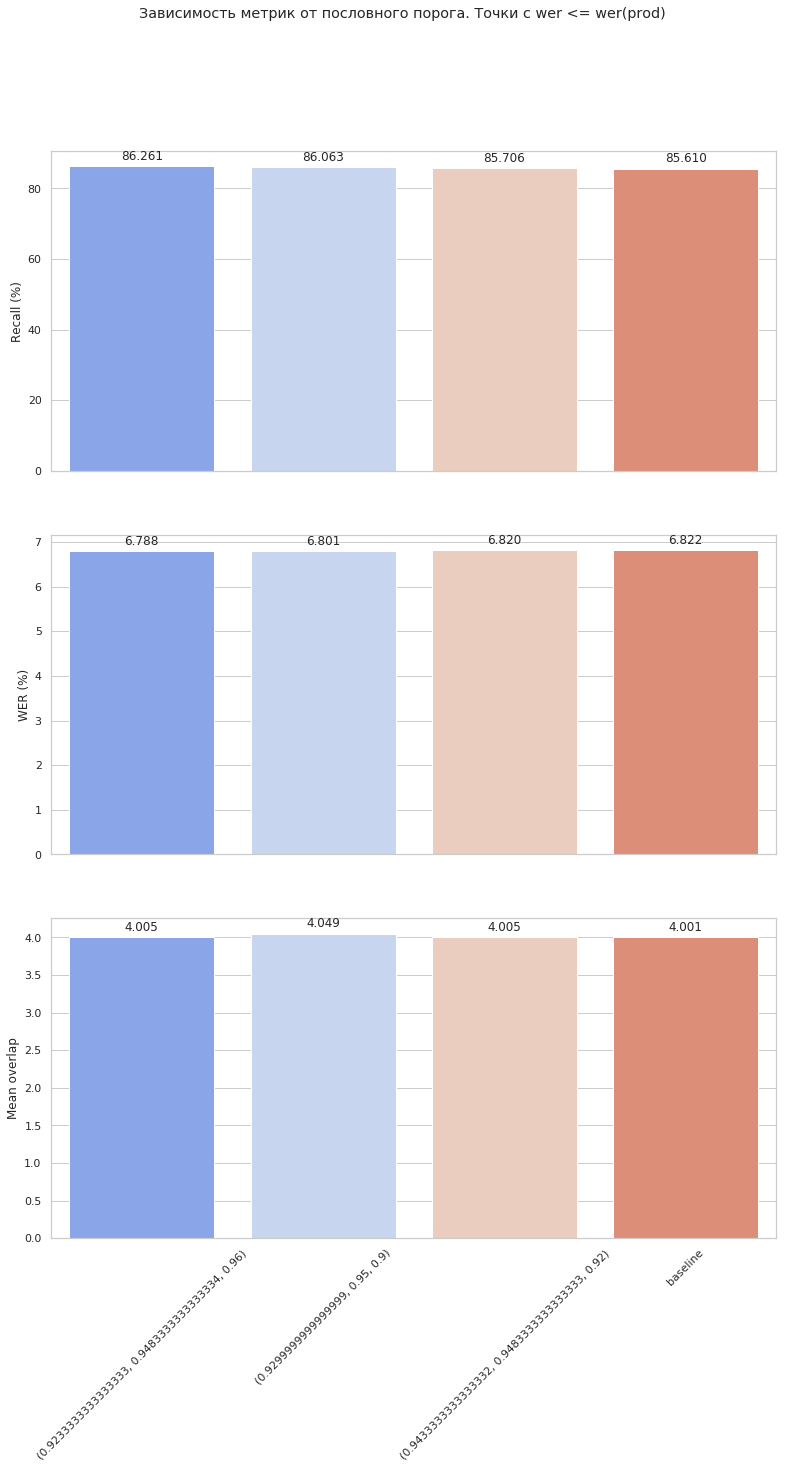

In [117]:
plt.figure(figsize=(13,20))
plt.suptitle('Зависимость метрик от пословного порога. Точки с wer <= wer(prod)')
plt.subplot(311)
plt.ylabel('Recall (%)')
ax = sns.barplot(x=list(map(str, [point[0] for point in needed_points2])), 
                 y=[point[1]*100 for point in needed_points2],
                 palette="coolwarm")
plt.xticks([], [])
for item in ax.get_xticklabels():
    item.set_rotation(45)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.3f'), 
                (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), 
                textcoords = 'offset points')

plt.subplot(312)
plt.ylabel('WER (%)')
ax = sns.barplot(x=list(map(str, [point[0] for point in needed_points2])), 
                 y=[point[2]*100 for point in needed_points2],
                 palette="coolwarm")
plt.xticks([], [])
for item in ax.get_xticklabels():
    item.set_rotation(45)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.3f'), 
                (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), 
                textcoords = 'offset points')

plt.subplot(313)
plt.ylabel('Mean overlap')
ax = sns.barplot(x=list(map(str, [point[0] for point in needed_points2])), 
                 y=[point[3] for point in needed_points2],
                 palette="coolwarm")
for item in ax.get_xticklabels():
    item.set_rotation(45)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.3f'), 
                (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig('../notebooks/plots/aggregate_by_word_3_th_best_choice.png')
plt.show()

In [ ]:
scores_clf_score_by_word_q_mean_v7 = defaultdict(list)

for threshhold_common in np.linspace(0.89, 0.95, 10):
    print('\ncommon: {}'.format(threshhold_common))
    for threshhold_exchange in [threshhold_common + 0.035, threshhold_common + 0.04, threshhold_common + 0.045]:
        print('exchange: {}'.format(threshhold_exchange))
        for th_by_word in np.linspace(0.9, 1, 21):
            print('by word: {}'.format(th_by_word))
            metrics = evaluate_metrics_clf_(valid_rows, 
                                            {}, 
                                            'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                            None, 
                                            threshhold_common,
                                            threshhold_exchange,
                                            min_cost=3,
                                            max_cost=7,
                                            agg_method=partial(aggregate_rover_with_clf_by_word, 
                                                               threshold_by_word=th_by_word,
                                                               treshhold = threshhold_exchange,
                                                               preaggregated=preaggregated))
            scores_clf_score_by_word_q_mean_v7[(threshhold_common, threshhold_exchange)].append((th_by_word, *metrics))
    scores_clf_score_by_word_q_mean_v7[(threshhold_common, threshhold_exchange)] = np.array(scores_clf_score_by_word_q_mean_v7[(threshhold_common, threshhold_exchange)])



common: 0.89
exchange: 0.925
by word: 0.9
Recall: 91.2639%
WER: 9.3640%
Mean overlap: 3.598
by word: 0.905
Recall: 91.2465%
WER: 9.3446%
Mean overlap: 3.598
by word: 0.91
Recall: 91.1993%
WER: 9.3412%
Mean overlap: 3.598
by word: 0.915
Recall: 91.1822%
WER: 9.3330%
Mean overlap: 3.598
by word: 0.92
Recall: 91.1701%
WER: 9.3366%
Mean overlap: 3.598
by word: 0.925
Recall: 91.1564%
WER: 9.3102%
Mean overlap: 3.598
by word: 0.93
Recall: 91.1495%
WER: 9.3123%
Mean overlap: 3.598
by word: 0.935
Recall: 91.1310%
WER: 9.3166%
Mean overlap: 3.598
by word: 0.9400000000000001
Recall: 91.1246%
WER: 9.3104%
Mean overlap: 3.598
by word: 0.9450000000000001
Recall: 91.0972%
WER: 9.3147%
Mean overlap: 3.598
by word: 0.95
Recall: 91.0726%
WER: 9.3120%
Mean overlap: 3.598
by word: 0.9550000000000001
Recall: 91.0234%
WER: 9.2934%
Mean overlap: 3.598
by word: 0.96
Recall: 90.9897%
WER: 9.2795%
Mean overlap: 3.598
by word: 0.965
Recall: 90.9318%
WER: 9.2440%
Mean overlap: 3.598
by word: 0.97
Recall: 90.894

In [ ]:
for threshold, metrics in scores_clf_score_by_word_q_mean_v7.items():
    prev = default
    for th_by_word, recall, wer, cost in metrics:
        if wer <= prev[2] and wer < baseline_loaded_new_metrics[2] \
            and recall > baseline_loaded_new_metrics[1] and recall > prev[1]:
            prev = ((*threshold, round(th_by_word, 3)), recall, wer, cost)
    if prev != default:
        needed_points2.append(prev)
needed_points2.sort(key=lambda x: x[1], reverse=True)

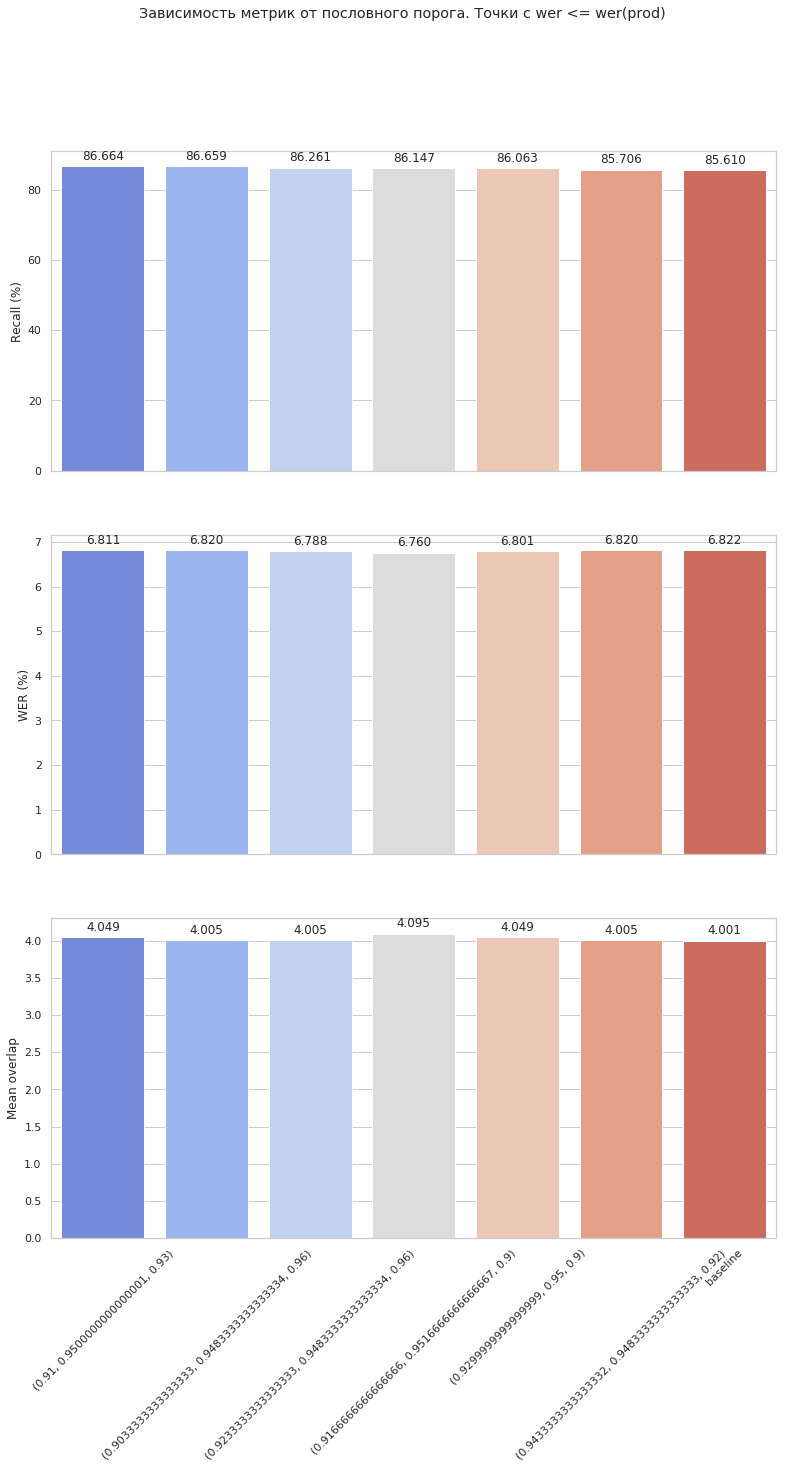

In [120]:
plt.figure(figsize=(13,20))
plt.suptitle('Зависимость метрик от пословного порога. Точки с wer <= wer(prod)')
plt.subplot(311)
plt.ylabel('Recall (%)')
ax = sns.barplot(x=list(map(str, [point[0] for point in needed_points2])), 
                 y=[point[1]*100 for point in needed_points2],
                 palette="coolwarm")
plt.xticks([], [])
for item in ax.get_xticklabels():
    item.set_rotation(45)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.3f'), 
                (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), 
                textcoords = 'offset points')

plt.subplot(312)
plt.ylabel('WER (%)')
ax = sns.barplot(x=list(map(str, [point[0] for point in needed_points2])), 
                 y=[point[2]*100 for point in needed_points2],
                 palette="coolwarm")
plt.xticks([], [])
for item in ax.get_xticklabels():
    item.set_rotation(45)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.3f'), 
                (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), 
                textcoords = 'offset points')

plt.subplot(313)
plt.ylabel('Mean overlap')
ax = sns.barplot(x=list(map(str, [point[0] for point in needed_points2])), 
                 y=[point[3] for point in needed_points2],
                 palette="coolwarm")
for item in ax.get_xticklabels():
    item.set_rotation(45)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.3f'), 
                (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig('../notebooks/plots/aggregate_by_word_3_th_best_choice.png')
plt.show()

In [134]:
np.array(scores_clf_score_by_word_q_mean_v7[(0.91, 0.9500000000000001)])[:, 0]

array([0.9  , 0.905, 0.91 , 0.915, 0.92 , 0.925, 0.93 , 0.935, 0.94 ,
       0.945, 0.95 , 0.955, 0.96 , 0.965, 0.97 , 0.975, 0.98 , 0.985,
       0.99 , 0.995, 1.   ])

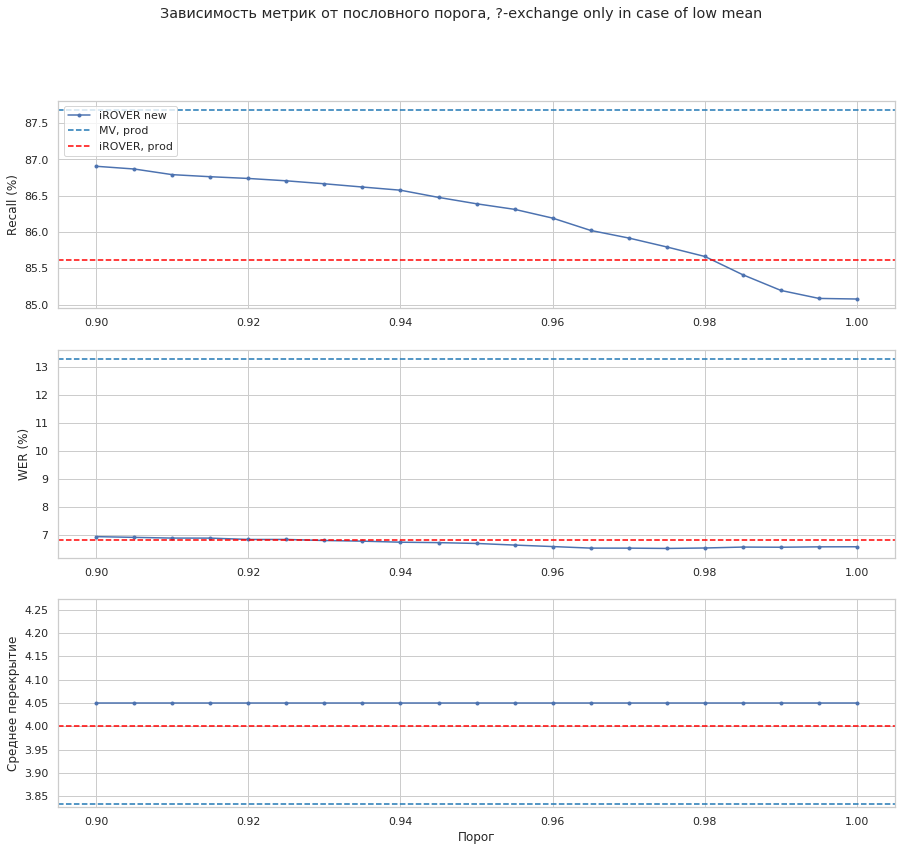

In [136]:
plt.figure(figsize=(15,13))
plt.suptitle('Зависимость метрик от пословного порога, ?-exchange only in case of low mean ')
plt.subplot(311)
for key, value in scores_clf_score_by_word_q_mean_v7.items():
    value = np.array(value)
    if key == (0.91, 0.9500000000000001):
        plt.plot(value[:, 0], 
                 value[:, 1] * 100, 
                 ".-", 
                 label='iROVER new')
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, prod")
plt.axhline(y=baseline_loaded_new_metrics[1] * 100, color='red', linestyle='--', label="iROVER, prod")
plt.legend(loc='upper left')
plt.ylabel('Recall (%)')

plt.subplot(312)
for key, value in scores_clf_score_by_word_q_mean_v7.items():
    value = np.array(value)
    if key == (0.91, 0.9500000000000001):
        plt.plot(value[:, 0], 
                 value[:, 2] * 100, 
                 ".-")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[2] * 100, color='red', linestyle='--')
plt.ylabel('WER (%)')

plt.subplot(313)
for key, value in scores_clf_score_by_word_q_mean_v7.items():
    value = np.array(value)
    if key == (0.91, 0.9500000000000001):
        plt.plot(value[:, 0], 
                 value[:, 3], 
                 ".-")
plt.axhline(y=prod_agg_metrics[2], color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[3], color='red', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')
# plt.savefig('../notebooks/plots/aggregate_by_word_different_th_by_word.png')
plt.show()

In [149]:
scores_clf_score_by_word_q_mean_v8 = defaultdict(list)

for threshhold_common in (0.91, ):
    print('\ncommon: {}'.format(threshhold_common))
    for threshhold_exchange in (0.95, ):
        print('exchange: {}'.format(threshhold_exchange))
        for th_by_word in np.linspace(0.895, 0.9025, 20):
            print('by word: {}'.format(th_by_word))
            metrics = evaluate_metrics_clf_(valid_rows, 
                                            {}, 
                                            'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                            None, 
                                            treshhold_common=0,
                                            treshhold_exchange=threshhold_exchange,
                                            min_cost=3,
                                            max_cost=7,
                                            agg_method=partial(aggregate_rover_with_clf_by_word, 
                                                               threshold_by_word=th_by_word,
                                                               treshhold = threshhold_exchange,
                                                               preaggregated=preaggregated))
            scores_clf_score_by_word_q_mean_v8[(threshhold_common, threshhold_exchange)].append((th_by_word, *metrics))
    scores_clf_score_by_word_q_mean_v8[(threshhold_common, threshhold_exchange)] = np.array(scores_clf_score_by_word_q_mean_v8[(threshhold_common, threshhold_exchange)])



common: 0.91
exchange: 0.95
by word: 0.895
Recall: 87.7828%
WER: 7.2274%
Mean overlap: 4.049
by word: 0.8953947368421052
Recall: 87.7799%
WER: 7.2280%
Mean overlap: 4.049
by word: 0.8957894736842106
Recall: 87.7632%
WER: 7.2223%
Mean overlap: 4.049
by word: 0.8961842105263158
Recall: 87.7632%
WER: 7.2223%
Mean overlap: 4.049
by word: 0.896578947368421
Recall: 87.7584%
WER: 7.2229%
Mean overlap: 4.049
by word: 0.8969736842105264
Recall: 87.7568%
WER: 7.2235%
Mean overlap: 4.049
by word: 0.8973684210526316
Recall: 87.7281%
WER: 7.1996%
Mean overlap: 4.049
by word: 0.8977631578947368
Recall: 87.7261%
WER: 7.2002%
Mean overlap: 4.049
by word: 0.8981578947368422
Recall: 87.6859%
WER: 7.1786%
Mean overlap: 4.049
by word: 0.8985526315789474
Recall: 87.6787%
WER: 7.1792%
Mean overlap: 4.049
by word: 0.8989473684210526
Recall: 87.6757%
WER: 7.1803%
Mean overlap: 4.049
by word: 0.8993421052631578
Recall: 87.6374%
WER: 7.1741%
Mean overlap: 4.049
by word: 0.8997368421052632
Recall: 87.6360%
WER:

In [151]:
scores_clf_score_by_word_q_mean_v8 = list()

for threshhold_common in np.linspace(0.981, 0.9826, 10):
    print('\ncommon: {}'.format(threshhold_common))
    threshhold_exchange = threshhold_common
    th_by_word = 0
    metrics = evaluate_metrics_clf_(valid_rows, 
                                    {}, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    None, 
                                    treshhold_common=0,
                                    treshhold_exchange=threshhold_exchange,
                                    min_cost=3,
                                    max_cost=7,
                                    agg_method=partial(aggregate_rover_with_clf_by_word, 
                                                       threshold_by_word=th_by_word,
                                                       treshhold = threshhold_exchange,
                                                       preaggregated=preaggregated))
    scores_clf_score_by_word_q_mean_v8.append((th_by_word, *metrics))
scores_clf_score_by_word_q_mean_v8 = np.array(scores_clf_score_by_word_q_mean_v8)


common: 0.981
Recall: 87.8823%
WER: 9.4355%
Mean overlap: 5.23

common: 0.9811777777777778
Recall: 87.8577%
WER: 9.4281%
Mean overlap: 5.241

common: 0.9813555555555555
Recall: 87.8577%
WER: 9.4281%
Mean overlap: 5.247

common: 0.9815333333333334
Recall: 87.7430%
WER: 9.4207%
Mean overlap: 5.253

common: 0.9817111111111111
Recall: 87.3701%
WER: 9.4281%
Mean overlap: 5.266

common: 0.9818888888888889
Recall: 87.1119%
WER: 9.4281%
Mean overlap: 5.272

common: 0.9820666666666666
Recall: 86.7103%
WER: 9.4281%
Mean overlap: 5.287

common: 0.9822444444444445
Recall: 86.3947%
WER: 9.4281%
Mean overlap: 5.296

common: 0.9824222222222222
Recall: 86.3947%
WER: 9.4281%
Mean overlap: 5.306

common: 0.9826
Recall: 86.3660%
WER: 9.4207%
Mean overlap: 5.313
